In [1]:
import torch
import torch.backends.cudnn
import os
gpu = torch.device('cuda')
os.environ["CUDA_VISIBLE_DEVICES"] = "7"  # Replace "0" with the index of the GPU you want to use (e.g., "0" for the first GPU).

In [2]:
def ctcloss_reference(log_probs, targets, input_lengths, target_lengths, blank=0, reduction='mean'):
    input_lengths = torch.as_tensor(input_lengths, dtype=torch.long)
    target_lengths = torch.as_tensor(target_lengths, dtype=torch.long)
    dt = log_probs.dtype
    log_probs = log_probs.double()  # we need the accuracy as we are not in logspace
    targets = targets.long()
    cum_target_lengths = target_lengths.cumsum(0)
    losses = []
    for i in range(log_probs.size(1)):
        input_length = input_lengths[i].item()
        target_length = target_lengths[i].item()
        cum_target_length = cum_target_lengths[i].item()
        # ==========================================================================================================
        targets_prime = targets.new_full((2 * target_length + 1,), blank)
        if targets.dim() == 2:
            targets_prime[1::2] = targets[i, :target_length]
        else:
            targets_prime[1::2] = targets[cum_target_length - target_length:cum_target_length]
        # ==========================================================================================================
        probs = log_probs[:input_length, i].exp()
        # ==========================================================================================================
        alpha = log_probs.new_zeros((target_length * 2 + 1,))
        alpha[0] = probs[0, blank]
        alpha[1] = probs[0, targets_prime[1]]
        mask_third = (targets_prime[:-2] != targets_prime[2:])
        for t in range(1, input_length):
            alpha_next = alpha.clone()
            alpha_next[1:] += alpha[:-1]
            alpha_next[2:] += torch.where(mask_third, alpha[:-2], alpha.new_zeros(1))
            alpha = probs[t, targets_prime] * alpha_next
        # ==========================================================================================================
        losses.append(-alpha[-2:].sum().log()[None])
    output = torch.cat(losses, 0)
    if reduction == 'mean':
        return (output / target_lengths.to(dtype=output.dtype, device=output.device)).mean()
    elif reduction == 'sum':
        return output.sum()
    output = output.to(dt)
    return output


In [3]:
import torch.nn as nn
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        # Forward pass
        out = self.linear(x).log_softmax(2)
        return out

In [4]:
bs = 1

In [5]:
target_lengths = torch.tensor([100]).cuda()
input_lengths =  torch.tensor([128]).cuda()
targets = torch.randint(1, 26, (sum(target_lengths),), dtype=torch.int).cuda()
# input     = torch.nn.Parameter(torch.randn(50,3,40).cuda(),requires_grad=True)
# weight    = torch.nn.Parameter(torch.randn(40,15).cuda(),  requires_grad=True)
asr_model = LinearModel(512,26).cuda()
grad_match= torch.zeros(26,512).cuda()

# ctc_pt_loss = torch.nn.CTCLoss()

In [7]:
torch.backends.cudnn.enabled = True

def meta_loss(logits, targets, input_lengths, target_lengths, grad_to_match, model_w):
    ctc_loss =  ctcloss_reference(logits, targets.cuda(), input_lengths, target_lengths).float()
    # ctc_loss =  ctc_pt_loss(logits, targets, input_lengths, target_lengths).float()
    dl_dw    =  torch.autograd.grad(ctc_loss, model_w , allow_unused=True, create_graph=True)
    mse_loss = ((dl_dw[0]-grad_match)**2).sum()
    return mse_loss

lr = 1
input_     = torch.nn.Parameter(torch.randn(128,bs,512).cuda(),requires_grad=True)

loss_history = []

for i in range(100):
    logits_ = asr_model(input_) 
    m_loss_ = meta_loss(logits_, targets, input_lengths, target_lengths, grad_match, asr_model.linear.weight)
    if i%10==0: print('epoch {} loss {}'.format(i, m_loss_.item()))

    loss_history.append(m_loss_.item())
    input_grad = torch.autograd.grad(m_loss_, input_)

    input_ = input_ - lr * input_grad[0]


epoch 0 loss 1.2189964056015015
epoch 10 loss 0.9262222051620483
epoch 20 loss 0.830561637878418
epoch 30 loss 0.8152076005935669
epoch 40 loss 0.8583961129188538
epoch 50 loss 0.8185175657272339
epoch 60 loss 0.7616852521896362
epoch 70 loss 0.8004385232925415
epoch 80 loss 0.7721843123435974
epoch 90 loss 0.7321271896362305


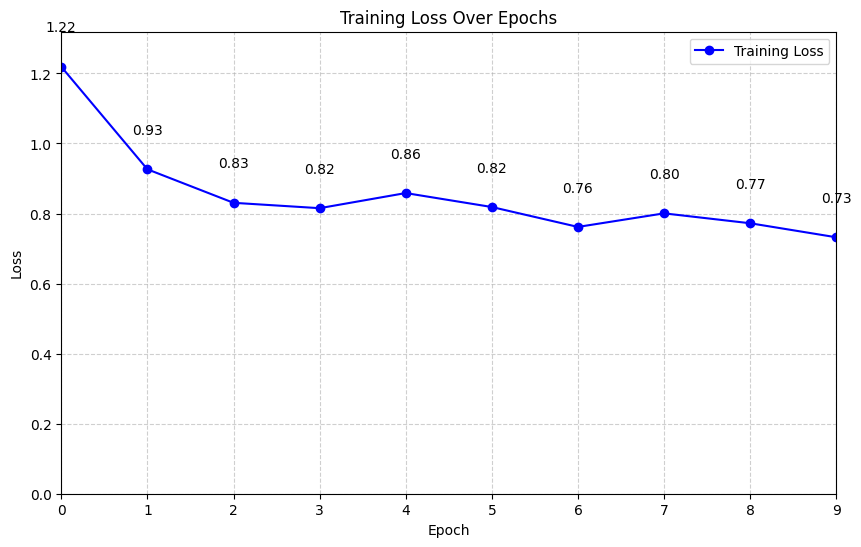

In [9]:
from utils import plot_loss_over_epochs

plot_loss_over_epochs(list(range(10)), loss_history[0:100:10])

### input -> grad -> match

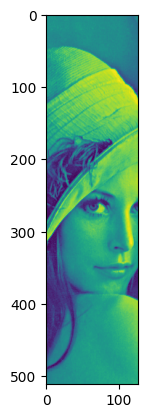

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
image = Image.open('lena.png') 
if image.mode != 'L':
    image = image.convert('L')
image = np.array(image)
image = image[:512, 200:200+128]
plt.imshow(image)
image = image / image.max()

In [5]:
target_lengths = torch.tensor([100]).cuda()
input_lengths =  torch.tensor([128]).cuda()
targets = torch.randint(1, 26, (sum(target_lengths),), dtype=torch.int).cuda()
# input     = torch.nn.Parameter(torch.randn(50,3,40).cuda(),requires_grad=True)
# weight    = torch.nn.Parameter(torch.randn(40,15).cuda(),  requires_grad=True)
asr_model = LinearModel(512,26).cuda()

In [16]:
inp = torch.nn.Parameter(torch.randn(128,bs,512).cuda().float(),requires_grad=True)
logits = asr_model(inp)
ctc_loss =  ctcloss_reference(logits, targets.cuda(), input_lengths, target_lengths).float()
ctc_loss.backward()

In [17]:
grad_match = asr_model.linear.weight.grad.data

In [18]:
grad_match

tensor([[-0.0085,  0.0091,  0.0291,  ...,  0.0428, -0.0130,  0.0073],
        [-0.0019,  0.0084, -0.0239,  ..., -0.0275, -0.0109, -0.0073],
        [ 0.0123,  0.0036,  0.0499,  ..., -0.0064, -0.0040, -0.0280],
        ...,
        [ 0.0027,  0.0149, -0.0156,  ..., -0.0078, -0.0053,  0.0032],
        [-0.0202, -0.0369, -0.0114,  ...,  0.0224,  0.0044, -0.0011],
        [-0.0228, -0.0129,  0.0084,  ..., -0.0017,  0.0245,  0.0104]],
       device='cuda:0')

In [21]:

input_ = inp + 0.0001 * torch.randn(128,bs,512).cuda()
input_ = input_.data
input_ = torch.nn.Parameter(input_.cuda(),requires_grad=True)

print('dist',torch.norm(input_ - inp).item())

dist 0.025648033246397972


In [24]:
def meta_loss(logits, targets, input_lengths, target_lengths, grad_to_match, model_w):
    ctc_loss =  ctcloss_reference(logits, targets.cuda(), input_lengths, target_lengths).float()
    # ctc_loss =  ctc_pt_loss(logits, targets, input_lengths, target_lengths).float()
    dl_dw    =  torch.autograd.grad(ctc_loss, model_w , allow_unused=True, create_graph=True)
    mse_loss = ((dl_dw[0]-grad_match)**2).sum()
    return mse_loss

lr = 0 #.0001

loss_history = []
reconstruct_distc = [0]

for i in range(1000):
    logits_ = asr_model(input_) 
    m_loss_ = meta_loss(logits_, targets, input_lengths, target_lengths, grad_match, asr_model.linear.weight)
    if i%10==0: print('epoch {} loss {} dist {}'.format(i, m_loss_.item(), reconstruct_distc[-1]))

    loss_history.append(m_loss_.item())
    input_grad = torch.autograd.grad(m_loss_, input_)

    input_ = input_ - lr * input_grad[0]

    reconstruct_distc.append(torch.norm(input_ - inp).item())


epoch 0 loss 1.7527762651443481 dist 0
epoch 10 loss 1.7527753114700317 dist 1.0089443922042847
epoch 20 loss 1.7527744770050049 dist 1.0089665651321411
epoch 30 loss 1.7527735233306885 dist 1.008988618850708
epoch 40 loss 1.752772569656372 dist 1.0090107917785645


KeyboardInterrupt: 